In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, healpy as hp
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

def save_figs(filename):
    plt.savefig(filename+'.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    plt.savefig(filename+'.pdf', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    plt.savefig(filename+'_c.pdf', bbox_inches='tight', dpi=50, facecolor='w', transparent=False)

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [11]:
import emcee

# Disk profile

In [ ]:
zmax = 1./np.tan(np.deg2rad(80))
zmax

In [56]:
R0 = 8.27
L = 2.6
z=3

def logmodel(coords, zmax=zmax, z=z, L=L, R0=R0):
    
    x,y=coords
    R = np.sqrt(y**2 + (R0-x)**2)
    
    if np.sqrt(x**2 + y**2)>zmax*z:
        return -1e20
    
    return -R/L

In [79]:
nwalkers=10; nstep=500000; ndim=2

runs = [{'z':0.3,'L':2.6,'R0':8.27},
        {'z':2.,'L':2.6,'R0':8.27},
        {'z':0.9,'L':3.6,'R0':8.27},
        {'z':2.,'L':3.6,'R0':8.27}]

R_runs = []

for ii, run in enumerate(runs):
    
    p0 = np.random.rand(nwalkers,ndim)*0.01

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logmodel, kwargs=run)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0, iterations=nstep), total=nstep):
        pass

    x, y = sampler.chain[:,2000:].reshape(-1,ndim).T
    R_runs.append(np.sqrt(y**2 + (R0-x)**2))

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

In [80]:
[np.mean(R)-8.27 for R in R_runs], [np.std(R)/np.sqrt(len(R)) for R in R_runs]

([-0.00021101280303703618,
  -0.00948326972685365,
  -0.0017046038161936394,
  -0.007778925913374479],
 [1.1855528107737558e-05,
  7.890620929533012e-05,
  3.5513926735222216e-05,
  7.905115154238063e-05])

([-0.0006375425334397278,
  -0.01237697941525262,
  -0.0005535208412599246,
  -0.006490564749034533],
 [3.752342107439791e-05,
  0.00024933882911690875,
  0.00011278215923440481,
  0.00025030844214341425])

In [65]:
np.mean(R), np.std(R)/np.sqrt(len(R))

(8.269883372090694, 5.579000141883723e-05)

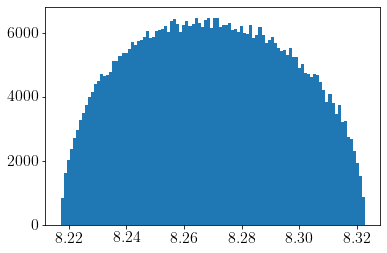

In [77]:
plt.hist(R_runs[0], bins=100);

# Halo

In [83]:
zmax = 1./np.tan(np.deg2rad(80))
R0 = 8.27

z=1
print(f"$l=0, z=1$ {np.sqrt(z**2 + R0**2) - np.sqrt(z**2 + 0.**2 + (R0-z*zmax)**2)}")
print(f"$l=180, z=1$ {np.sqrt(z**2 + R0**2) - np.sqrt(z**2 + 0.**2 + (R0+z*zmax)**2)}")

z=10
print(f"$l=0, z=10$ {np.sqrt(z**2 + R0**2) - np.sqrt(z**2 + 0.**2 + (R0-z*zmax)**2)}")
print(f"$l=180, z=10$ {np.sqrt(z**2 + R0**2) - np.sqrt(z**2 + 0.**2 + (R0+z*zmax)**2)}")

$l=0, z=1$ 0.175024403020684
$l=180, z=1$ -0.17507821216742414
$l=0, z=10$ 1.0460993390578324
$l=180, z=10$ -1.1890514723266676


In [131]:
def logmodel(coords, zmax=zmax, R0=R0, n=-3.724):
    
    x,y,z=coords
    #print(np.sqrt(x**2+y**2))
    r2 = z**2 + y**2 + (R0-x)**2
    
    if (np.sqrt(x**2 + y**2)>zmax*z)|(z<0):
        return -1e20
    
    return n/2 * np.log(r2)

In [147]:
nwalkers=10; nstep=50000; ndim=3

runs = [{'n':-3.724}]

xyz_runs = []

for ii, run in enumerate(runs):
    
    p0 = np.random.rand(nwalkers,ndim)
    p0[:,2] +=5 
    p0[:,:2] *= zmax

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logmodel, kwargs=run)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0, iterations=nstep), total=nstep):
        pass
    
    xyz_runs.append(sampler.chain[:,int(nstep/2):].reshape(-1,ndim).T)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/50000 [00:00<?, ?it/s]

In [148]:
x,y,z = xyz_runs[0]
r = np.sqrt(z**2 + y**2 + (R0-x)**2)
r_wrong = np.sqrt(z**2 + R0**2)

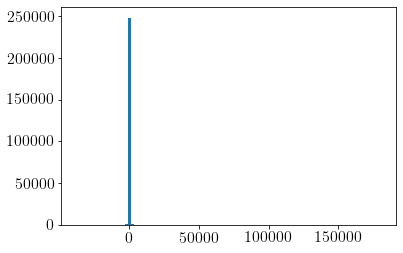

In [149]:
plt.hist(x, bins=100);

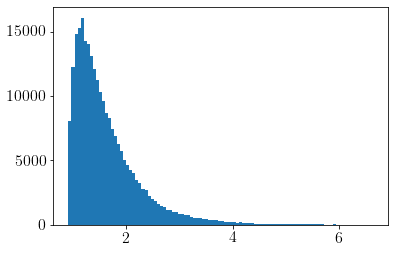

In [150]:
plt.hist(np.log10(r), bins=100);

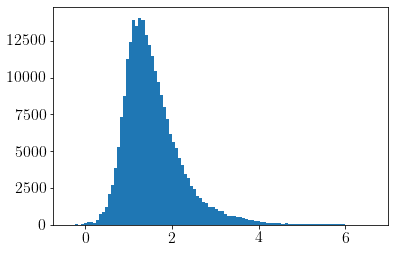

In [151]:
plt.hist(np.log10(z), bins=100);

In [154]:
np.mean((r_wrong-r)/r)

-0.002893147831282386

In [155]:
np.mean(np.abs((r_wrong-r)/r))

0.020936549082273048

In [145]:
np.mean((r-r_wrong)/r)

0.003013599753864296

In [146]:
np.mean(np.abs((r-r_wrong)/r))

0.02066025869418443

# Sample 6 data

# Load data

In [7]:
from TracerFit import mwfit, int_idx

In [63]:
size = 5000000; smax=np.inf; sid=None
samples={}
sample_names=['5','6','_dr3asf']
for i in sample_names:
    filename = f'/data/asfe2/Projects/mwtrace_data/mockmodel/sample{i}.h'
    # Load Sample
    sample = {}; true_pars={}; latent_pars={};
    magcuts = [-100,200]
    with h5py.File(filename, 'r') as hf:
        subset = (hf['sample']['m'][...]>magcuts[0])&(hf['sample']['m'][...]<magcuts[1])&(hf['sample']['s'][...]<smax)
        if sid is None:
            print('low', np.sum(hf['sample']['m'][...]<magcuts[0]))
            print('high', np.sum(hf['sample']['m'][...]>magcuts[1]))
            print('%d/%d' % (np.sum(subset), len(subset)))
            subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
        else:
            subsample = np.intersect1d(hf['sample']['source_id'][...][subset], sid, return_indices=True)[1]

        for key in hf['sample'].keys():
            sample[key]=hf['sample'][key][...][subset][subsample]
        # Get true parameters
        for key in hf['true_pars'].keys():
            if not key in np.arange(3).astype(str):
                true_pars[int_idx(key)]=hf['true_pars'][key][...]
            else:
                true_pars[int_idx(key)]={}
                for par in hf['true_pars'][key].keys():
                    true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
    for j in range(3): true_pars[j]['w']*=size
    samples[i]=sample

low 0
high 0
5000000/5000000
low 0
high 0
5000000/5000000
low 0
high 0
5000000/5000000


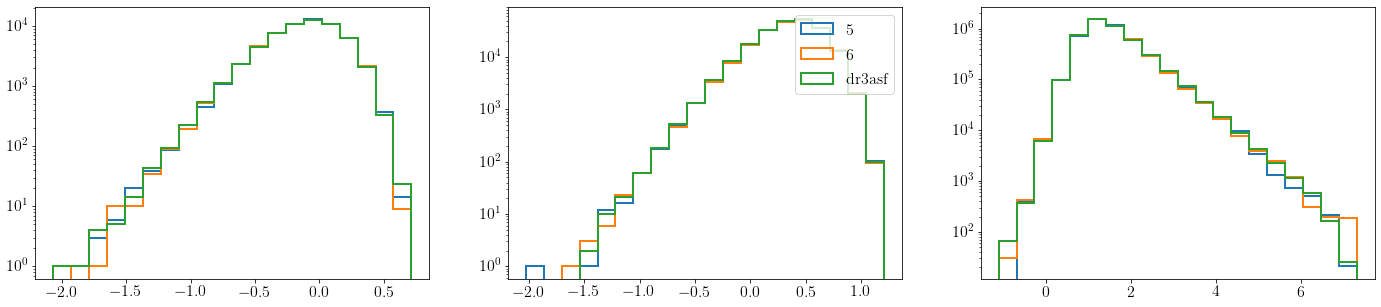

In [64]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

for j in range(3):
    minmax = (min([np.min(samples[name]['s'][samples[name]['cmpt']==j]) for name in sample_names]),
              max([np.max(samples[name]['s'][samples[name]['cmpt']==j]) for name in sample_names]))
    for name in sample_names:
        plt.sca(axes[j])
        plt.hist(np.log10(samples[name]['s'][samples[name]['cmpt']==j]), 
                 bins=20, range=np.log10(minmax), histtype='step', linewidth=2, label=name.replace('_',''));
        plt.yscale('log')
    if j==1: plt.legend()

In [65]:
for i in sample_names:
    cosb = np.sqrt(1-samples[i]['sinb']**2)
    cosl = np.cos(samples[i]['l'])
    samples[i]['r'] = np.sqrt(samples[i]['s']**2 + true_pars['R0']**2 - 2*true_pars['R0']*samples[i]['s']*cosl*cosb)
    d = samples[i]['s']*cosb
    samples[i]['R'] = np.sqrt( true_pars['R0']**2 + d**2 - 2*true_pars['R0']*d*cosl )

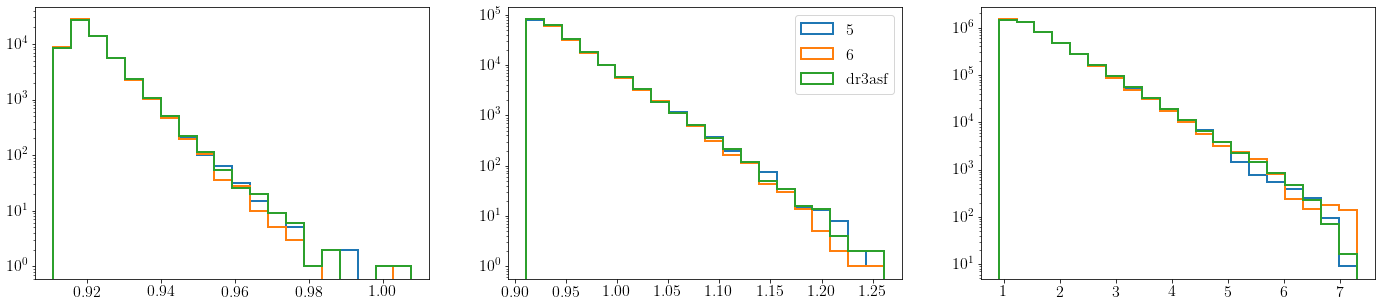

In [66]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

for j in range(3):
    minmax = (min([np.min(samples[name]['r'][samples[name]['cmpt']==j]) for name in sample_names]),
              max([np.max(samples[name]['r'][samples[name]['cmpt']==j]) for name in sample_names]))
    for i in sample_names:
        plt.sca(axes[j])
        plt.hist(np.log10(samples[i]['r'][samples[i]['cmpt']==j]), 
                 bins=20, range=np.log10(minmax), histtype='step', linewidth=2, label=i.replace('_',''));
        plt.yscale('log')
    if j==1: plt.legend()

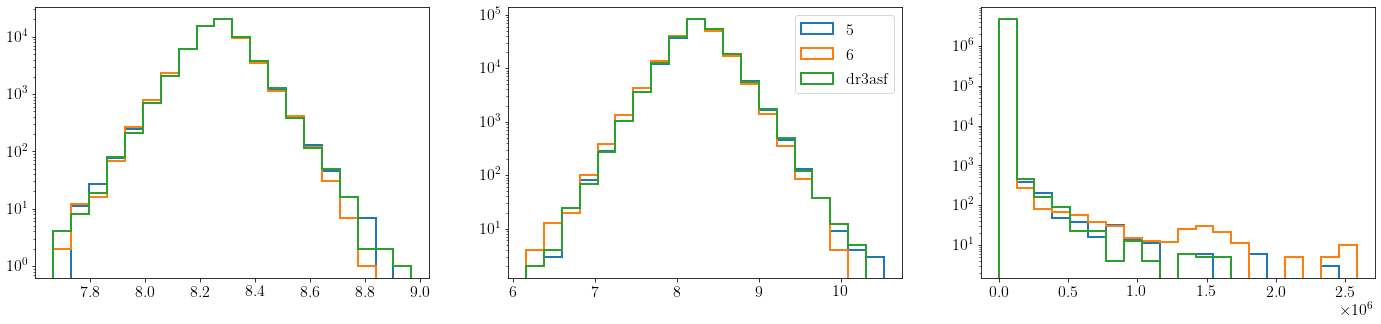

In [67]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

for j in range(3):
    minmax = (min([np.min(samples[name]['R'][samples[name]['cmpt']==j]) for name in sample_names]),
              max([np.max(samples[name]['R'][samples[name]['cmpt']==j]) for name in sample_names]))
    for i in sample_names:
        plt.sca(axes[j])
        plt.hist(samples[i]['R'][samples[i]['cmpt']==j], 
                 bins=20, range=minmax, histtype='step', linewidth=2, label=i.replace('_',''));
        plt.yscale('log')
    if j==1: plt.legend()

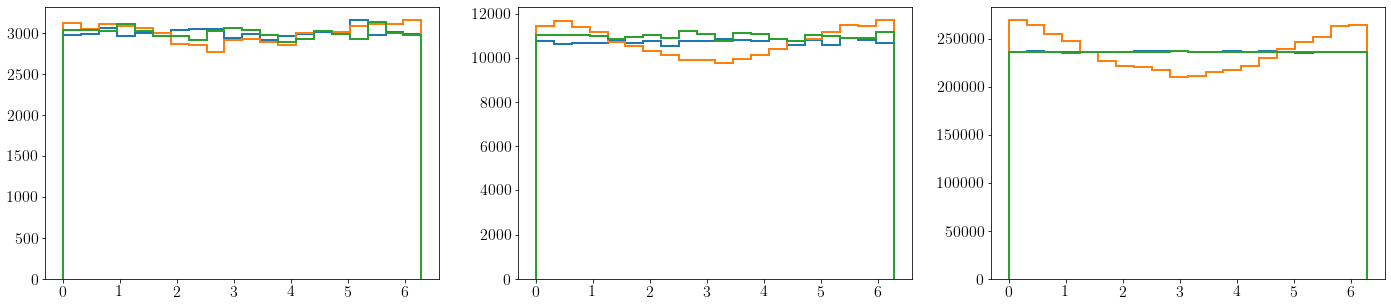

In [68]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

for j in range(3):
    plt.sca(axes[j])
    for i in sample_names:
        samples[i]['l'][samples[i]['l']<0] += 2*np.pi
        plt.hist(samples[i]['l'][samples[i]['cmpt']==j], 
                 bins=20, range=[0,2*np.pi], histtype='step', linewidth=2, label=i.replace('_',''));
        #plt.yscale('log')